# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/Bhc7RVE.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!

> NOTE: We'll be following along with the official LangGraph implementation very closely, which you can find [here](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb), with some minor modifications and extensions to showcase just how straightforward it is to modify LangGraph implementations to suit your own needs!



## Dependencies

We'll start, as we normally do, by grabbing our dependencies.

We'll be using LangChain and LangGraph to power our application, so let's start by grabbing those!

In [1]:
!pip install -qU  langchain langchain_openai langgraph langchain_experimental

We're going to be showing a simple RAG chain as part of our LangGraph - and so we'll need specific dependencies for that as well!

In [2]:
!pip install -qU --disable-pip-version-check qdrant-client pymupdf tiktoken

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

##### 😀😀😀 Let's trace our graph with LangSmith

In [4]:
# 😀 my own cell

os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGSMITH_PROJECT"] = "AIE4_WEEK3_DAY2"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LANGSMITH API Key:")

## Simple LCEL RAG

Now that we have our dependencies set-up - let's create a simple RAG chain that works over a single PDF.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [5]:
from langchain.document_loaders import PyMuPDFLoader

docs = PyMuPDFLoader("https://arxiv.org/pdf/2404.19553").load()

In [6]:
# 😀 my own cell

print(type(docs))
print(len(docs))
print(type(docs[0]))
print("="*20)

print(docs[0].metadata)
print("="*20)
print(docs[0].page_content[:100])

<class 'list'>
5
<class 'langchain_core.documents.base.Document'>
{'source': 'https://arxiv.org/pdf/2404.19553', 'file_path': 'https://arxiv.org/pdf/2404.19553', 'page': 0, 'total_pages': 5, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20240501003931Z', 'modDate': 'D:20240501003931Z', 'trapped': ''}
Extending Llama-3’s Context Ten-Fold Overnight
Peitian Zhang1,2, Ninglu Shao1,2, Zheng Liu1∗
, Shita


Now we can chunk it down to size!

In [7]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

split_chunks = text_splitter.split_documents(docs)

In [8]:
# 😀 my own cell

print(type(split_chunks))
print(len(split_chunks))
print(type(split_chunks[0]))
print("="*20)

print(split_chunks[0].metadata)
print("="*20)
print(split_chunks[0].page_content[:100])
print(tiktoken_len(split_chunks[0].page_content))

<class 'list'>
15
<class 'langchain_core.documents.base.Document'>
{'source': 'https://arxiv.org/pdf/2404.19553', 'file_path': 'https://arxiv.org/pdf/2404.19553', 'page': 0, 'total_pages': 5, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20240501003931Z', 'modDate': 'D:20240501003931Z', 'trapped': ''}
Extending Llama-3’s Context Ten-Fold Overnight
Peitian Zhang1,2, Ninglu Shao1,2, Zheng Liu1∗
, Shita
294


Now we've successfully split our single PDF into...

In [9]:
len(split_chunks)

15

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [10]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [ ]:
# from langchain_community.vectorstores import Qdrant

# qdrant_vectorstore = Qdrant.from_documents(
#     split_chunks,
#     embedding_model,
#     location=":memory:",
#     collection_name="extending_context_window_llama_3",
# )

##### 😀😀😀 Deprecation warning!
I found out that "from langchain_community.vectorstores import Qdrant" is deprecated. \
So I will try "from langchain_qdrant.qdrant import QdrantVectorStore" instead.

In [11]:
# 😀 my own cell

# https://api.python.langchain.com/en/latest/_modules/langchain_qdrant/qdrant.html#QdrantVectorStore

from langchain_qdrant.qdrant import QdrantVectorStore

qdrant_vectorstore = QdrantVectorStore.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="extending_context_window_llama_3",
)

Let's make sure we can access it as a retriever.

In [12]:
qdrant_retriever = qdrant_vectorstore.as_retriever()
qdrant_retriever = qdrant_retriever.with_config({'run_name':"Retriever"}) # 😀 I bind run_name

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [13]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

# rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)


rag_prompt = ChatPromptTemplate([('human', RAG_PROMPT)]) # 😀 I prefer this way

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [14]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini", name="RAG_LLM")
openai_chat_model = openai_chat_model.with_config({'run_name':"RAG_LLM"}) # 😀 I bind run_name

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single chain - and we're off!

In [15]:
from langchain.schema.output_parser import StrOutputParser
from langchain_core.runnables import Runnable

isinstance( StrOutputParser(), Runnable)

True

In [16]:
# from operator import itemgetter
# from langchain.schema.output_parser import StrOutputParser

# rag_chain = (
#     {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
#     | rag_prompt | openai_chat_model | StrOutputParser()
# )


# 😀 I prefer this way of implementing a RAG
from langchain.schema.output_parser import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from operator import itemgetter

rag_chain = (
    RunnablePassthrough().assign(context= itemgetter('question') | qdrant_retriever | RunnableLambda(lambda x: '\n\n'.join([doc.page_content for doc in x]))).with_config({'run_name':"[RetrievingContext]"})  |
    rag_prompt.with_config({'run_name':"[RAGPrompt]"}) | 
    ChatOpenAI(model="gpt-4o-mini", name="[RAG_LLM]").with_config({'run_name':"[RAGLLM]"}) | 
    StrOutputParser()
).with_config({'run_name':'[RAGChain]'})

Let's test this out and make sure it works.

In [17]:
rag_chain.invoke({"question" : "What does the 'context' in 'long context' refer to?"})

"In the context of 'long context' as mentioned in the provided text, 'context' refers to the amount of textual information (such as a book or a long paper) that a large language model (LLM) can process and analyze. Specifically, it pertains to the length of the input data that the model can handle at one time, which in this case has been extended from 8,000 tokens to 80,000 tokens for the Llama-3-8B-Instruct model."

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

##### 😀😀😀 🏗️ Activity #1  Let's leverage the arxiv agent

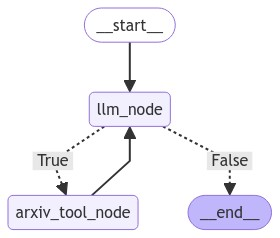

'The term "long context" typically refers to the amount of information or data that is considered when processing or understanding a particular situation, text, or conversation. In various fields, such as natural language processing (NLP), "long context" can mean the ability of a model or system to take into account a larger span of text or previous interactions to generate more coherent and contextually relevant responses.\n\nIn the context of language models, for example, a "long context" allows the model to remember and utilize information from earlier parts of a conversation or document, which can lead to better understanding and more accurate outputs. This is particularly important in tasks that require maintaining coherence over longer dialogues or texts, where earlier information is crucial for interpreting later content. \n\nIf you have a specific context or field in mind where "long context" is used, please provide more details for a more tailored explanation.'

In [18]:
# 😀 my own cell

## Set up AgentState
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages 
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

## Set up an uncompiled graph
from langgraph.graph import StateGraph, END
uncompiled_graph = StateGraph(AgentState)

## Set up the tool belt (arvix tool)
from langgraph.prebuilt import ToolNode
from langchain_community.tools.arxiv.tool import ArxivQueryRun
tools = [ArxivQueryRun()]
uncompiled_graph.add_node('arxiv_tool_node', ToolNode(tools))

## Set up an llm node
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
reasoning_engine = ChatOpenAI(model="gpt-4o-mini", temperature=0, name="reasoning_engine").bind_tools(tools)

def llm_node(agent_state: AgentState):
    messages = agent_state['messages']
    response = reasoning_engine.invoke(messages)
    return {"messages": [response]}

uncompiled_graph.add_node('llm_node', llm_node)


## Set up entrypoint
uncompiled_graph.set_entry_point('llm_node')


## Set up conditional edge
def is_tool_called(agent_state: AgentState):
    return True if agent_state['messages'][-1].tool_calls else False

uncompiled_graph.add_conditional_edges('llm_node', is_tool_called, {True:'arxiv_tool_node', False:END})


## Set up an cycle
uncompiled_graph.add_edge('arxiv_tool_node', 'llm_node')


## Compile the graph
compiled_graph = uncompiled_graph.compile()

# Let's visualize the graph
from IPython.display import display, Image
display(Image( compiled_graph.get_graph().draw_mermaid_png() ))

## Wrap the graph for the sake of convenience
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import HumanMessage

state_machine = RunnableLambda(lambda x: {'messages':[HumanMessage(content=x)]}) | compiled_graph | RunnableLambda(lambda x: x['messages'][-1].content)
state_machine = state_machine.with_config({'run_name':'RAG_chain_by_LangGraph'})
state_machine.invoke("What does the 'context' in 'long context' refer to?")

## Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [19]:
from typing import Any, Callable, List, Optional, TypedDict, Union, Literal

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

##### 😀😀😀 My opinions
- 'node' for LangGraph should be a callable which takes in 'state (dictonary)' and returns a Dictionay where the keys of the returning dictionary are subset of the keys of 'state' 
- The following function 'agent_node' is to be converted into a callable with only one input argument 'state' by functools.partial()

In [73]:
# 😀 Modification_1: I changed the function name from 'agent_node' to 'member_node'.
# 😀 Modification_2: I made some modification on arguments

def member_node(state: dict, team: Literal['ResearchTeam', 'DocumentTeam'], member: AgentExecutor, name: str):
    result = member.invoke(state)
    if team=='ResearchTeam':
        return {"messages_for_research_team": [HumanMessage(content=result["output"], name=name)]}
    elif team=='DocumentTeam':    
        state['per_member_messages_for_document_team'] = []
        return {"messages_for_document_team": [HumanMessage(content= f"[Work from {name}]: " + result["output"], name=name)], "per_member_messages_for_document_team": []}  
    else:
        raise ValueError("Invalid team")

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

##### 😀😀😀 My opinions
- 'AgentExecutor' is an old way of creating an agent in LangChain.
- It is not as powerful as LangGraph but is simple enough to use as a component agent.

In [21]:
# 😀 I changed the function name from 'create_agent' to 'get_member' for better understaning

def get_member(
    team: Literal['ResearchTeam', 'DocumentTeam'], # 😀 added this
    name: str, # 😀 added this
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> AgentExecutor:
    """Create a function-calling agent and add it to the graph."""
    
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages_for_research_team" if team=='ResearchTeam' else "per_member_messages_for_document_team"), # 😀 modified this
            MessagesPlaceholder(variable_name="agent_scratchpad"),  
        ]
    ).with_config({'run_name': f'[{name}Prompt]'})

    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools).with_config({'run_name': f'{name}Agent'})
    
    # 😀 For an agent executor, the variable 'agent_scratchpad' or 'intermediate_steps' are not something we manually pass. 
    return executor

sample_member = get_member(team='ResearchTeam', name='Search', llm=ChatOpenAI(model="gpt-4o-mini"), tools=[ArxivQueryRun()], system_prompt="")
sample_member

RunnableBinding(bound=AgentExecutor(agent=RunnableAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_function_messages(x['intermediate_steps']))
})
| RunnableBinding(bound=ChatPromptTemplate(input_variables=['agent_scratchpad', 'messages_for_research_team', 'team_members'], input_types={'messages_for_research_team': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemp

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [22]:
# 😀 I changed the function name from 'create_team_supervisor' to 'get_supervisor' for better understaning
from langchain_core.runnables import RunnableSequence

def get_supervisor(team: str, team_members: list[str], llm: ChatOpenAI, system_prompt) -> RunnableSequence: # 😀 Add an additional argument 'team_name'
    """An LLM-based router."""
    options = ["FINISH"] + team_members
    
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages_for_research_team" if team=='ResearchTeam' else "messages_for_document_team" if team=='DocumentTeam' else "messages"), # 😀 modified this
            (
                "system", 
                "Given the conversation above, who should act next?" 
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    # ).partial(options=str(options), team_members=", ".join(members))
    ).partial(options=str(options)).with_config({'run_name':f'[{team}SupervisorPrompt]'}) 
    
    return (
            prompt   | 
            llm.bind_functions(functions=[function_def], function_call="route") | 
            JsonOutputFunctionsParser() # 😀 This parser makes the output a dictionary {'next': ${next}}
    ).with_config({'run_name':f'[{team}SupervisorChain]'})
    # 😀 The input of this chain would be {'messages': ${messages}, 'team_members':${team_members}} because of .partial() mothod run.


sample_superviosr = get_supervisor(team='ResearchTeam', team_members=['Search', 'PaperInformationRetriever'], llm=ChatOpenAI(model="gpt-4o-mini"), system_prompt="You are the supervisor of the Research Team. The members are: {team_members}.")
sample_superviosr    

RunnableBinding(bound=RunnableBinding(bound=ChatPromptTemplate(input_variables=['messages_for_research_team', 'team_members'], input_types={'messages_for_research_team': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'options': "['FINISH', 'Search', 'PaperInformationRetriever']"}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['team_members'], template='You are the supervisor of the Research Team. The members are: {team_members}.')), MessagesPlaceholder(variable_name='messages_for_research_team'), SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['options'], template='Given the conversation above, who should act next? Or should we FINISH? Select one of: {options}'))]), config={'run_

## Research Team - A LangGraph for Researching A Specific Topic

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic.

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [23]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [24]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

# 😀 Convert a chain into a tool 
@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    )-> Annotated[str, "answer to the query"]: 
  """Use Retrieval Augmented Generation to retrieve information about the 'Extending Llama-3’s Context Ten-Fold Overnight' paper."""
  return rag_chain.invoke({"question" : query})

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [25]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools
from langgraph.graph.message import add_messages

class ResearchTeamState(TypedDict):
    messages_for_research_team: Annotated[List[BaseMessage], add_messages] # 😀 Modified the name
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4-turbo` today. This LLM is going to be doing a lot of reasoning - and so using a "powerful" LLM is very important here!

In [26]:
llm = ChatOpenAI(model="gpt-4-turbo")

##### ❓ Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

##### 😀😀😀 Answer to Qeustion #1

Agent does its job based on 'routing' and 'cycle' where routing refers to selecting what is next.

If routing is not of very high quality, the agent can't make good use of the output from what's next.

It might lead either a poor final response of the agent or unnecessary cycling.

This is why it would be better to adopt a more powerful llm for routing.

### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4 Turbo model, and then create its node - and name it `Search`.

In [39]:
search_agent = get_member(
    team = 'ResearchTeam', 
    name = 'Search',
    llm = ChatOpenAI(model="gpt-4-turbo", name='SearchLLM').with_config({'run_name':"[SearchLLM]"}), 
    tools = [tavily_tool],
    system_prompt = "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)

search_node = functools.partial(member_node, team='ResearchTeam', member=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [40]:
rag_agent = get_member(
    team = 'ResearchTeam', 
    name = 'PaperInformationRetriever',
    llm = ChatOpenAI(model="gpt-4-turbo", name='PaperInformationRetrieverLLM').with_config({'run_name':"[PaperInformationRetrieverLLM]"}), 
    tools = [retrieve_information],
    system_prompt = "You are a research assistant who can provide specific information on the provided paper: 'Extending Llama-3’s Context Ten-Fold Overnight'. You must only respond with information about the paper related to the request.",
)

PaperInformationRetriever_node = functools.partial(member_node, team='ResearchTeam', member=rag_agent, name="PaperInformationRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [41]:
# 😀 I added [REMEMBER]~~ to the system_prompt 

ResearchTeamSupervisor_node = get_supervisor(
    team="ResearchTeam",
    team_members=["Search", "PaperInformationRetriever"],
    llm=ChatOpenAI(model="gpt-4-turbo", name='ResearchTeamSupervisor_LLM').with_config({'run_name':"[ResearchTeamSupervisor_LLM]"}),
    system_prompt=("You are a supervisor of tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."
    "[REMEMBER] You should ask all of your team members to do their job at least once before finishing."
    ),
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [42]:
research_graph = StateGraph(ResearchTeamState)

# 😀 supervisor 
research_graph.add_node("ResearchTeamSupervisor", ResearchTeamSupervisor_node)  

# 😀 agents
research_graph.add_node("Search", search_node)
research_graph.add_node("PaperInformationRetriever", PaperInformationRetriever_node)


Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [43]:
research_graph.add_edge("Search", "ResearchTeamSupervisor")
research_graph.add_edge("PaperInformationRetriever", "ResearchTeamSupervisor")
research_graph.add_conditional_edges(
    "ResearchTeamSupervisor",
    lambda x: x["next"],
    {"Search": "Search", "PaperInformationRetriever": "PaperInformationRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

##### 😀😀😀 Let's equip our graph with memory
[reference](https://langchain-ai.github.io/langgraph/reference/checkpoints/)

In [44]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

connect = sqlite3.connect(":memory:", check_same_thread=False)
checkpointer = SqliteSaver(connect)

In [45]:
research_graph.set_entry_point("ResearchTeamSupervisor")
research_graph = research_graph.compile(checkpointer=checkpointer).with_config({'run_name': '[ResarchTeamGraph]' }) # 😀 add checkpointer!!!

#### Display Graph

In [ ]:
# !pip install -qU python_mermaid

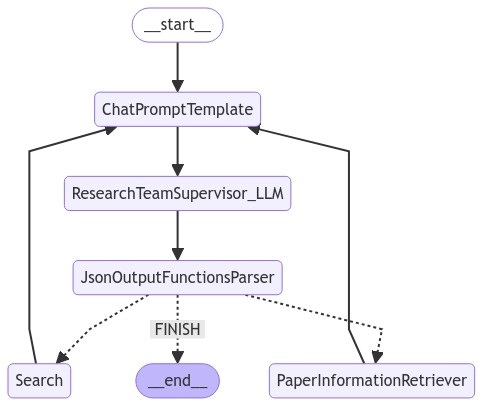

In [46]:
from IPython.display import Image, display

try:
    display(Image(research_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

##### 😀😀😀 Looking at 'enter_chain' function below, we can see that Research Team does not see other messages coming from outside of itself at all ('messages' is initialized from the input message string.)

In [47]:
from langchain_core.runnables import RunnableLambda


def enter_chain(message: str):
    input_to_graph = {
        "messages_for_research_team": [HumanMessage(content=message)],
        "team_members": ", ".join([node for node in research_graph.nodes if node not in [ '__start__', 'ResearchTeamSupervisor']] ),
    }
    return input_to_graph


research_e2e_chain = RunnableLambda(enter_chain).with_config({'run_name':'[PreludeToGraph]'}) | research_graph
research_e2e_chain = research_e2e_chain.with_config({'run_name':'[ResearchTeamE2EChain]'})

Now, finally, we can take it for a spin!

In [48]:
# 😀 Slightly modified. 

thread_info = {'configurable': {'thread_id': 'Research_checkpoint_1'}} # 😀 this is for a checkpoint!!


for s in research_e2e_chain.stream(
    "What are the main takeaways from the paper `Extending Llama-3's Context Ten-Fold Overnight'? Please use both Search and PaperInformationRetriever!", config={"recursion_limit": 100, **thread_info}
):  
    if "__end__" not in s:
        print(s)
        print("---")


{'ResearchTeamSupervisor': {'next': 'Search'}}
---
{'Search': {'messages_for_research_team': [HumanMessage(content='The main takeaways from the paper "Extending Llama-3\'s Context Ten-Fold Overnight" are as follows:\n\n1. **Context Extension**: The paper reports on the successful extension of the context length of the Llama-3-8B-Instruct model from 8,000 tokens to 80,000 tokens. This was achieved through a technique called QLoRA fine-tuning.\n\n2. **Efficiency of Training**: The training process described in the paper was highly efficient, completing within just 8 hours using a single machine equipped with 8xA800 (80G) GPUs.\n\n3. **Performance**: Despite the significant increase in context length, the resulting model maintained decent performance on tasks involving long contexts.\n\nThis research demonstrates a significant advancement in the capabilities of language models, particularly in handling much longer contexts than previously possible, which can greatly enhance their utility 

##### 😀😀😀 Let's take a look at our state stored as a checkpoint!!

In [49]:
lateset_state = research_graph.get_state(thread_info).values

lateset_state

{'messages_for_research_team': [HumanMessage(content="What are the main takeaways from the paper `Extending Llama-3's Context Ten-Fold Overnight'? Please use both Search and PaperInformationRetriever!", id='7ea1eaaa-3bc6-47b4-b643-cdde0f49b040'),
  HumanMessage(content='The main takeaways from the paper "Extending Llama-3\'s Context Ten-Fold Overnight" are as follows:\n\n1. **Context Extension**: The paper reports on the successful extension of the context length of the Llama-3-8B-Instruct model from 8,000 tokens to 80,000 tokens. This was achieved through a technique called QLoRA fine-tuning.\n\n2. **Efficiency of Training**: The training process described in the paper was highly efficient, completing within just 8 hours using a single machine equipped with 8xA800 (80G) GPUs.\n\n3. **Performance**: Despite the significant increase in context length, the resulting model maintained decent performance on tasks involving long contexts.\n\nThis research demonstrates a significant advanceme

##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.

### 😀 Activity #2

![ls](collapsed_langsmith.png)
![flow](flow.png)

##### ❓ Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?

### 😀 Answer to Question #2

One thing I found challenging is that sometimes 'supervisor' calls only one agent (either 'Search' or 'RAG'). In order to keep if from doing so, I added a single word 'both' to the system prompt for 'supervisor'.\
Instead of "Please use Search and PaperInformationRetriever!", I passed in "Please use **'both'** Search and PaperInformationRetriever!". In that way, I could see 'supervisor' call both agents more. 

## Document Writing Team - A LangGraph for Writing, Editing, and Planning a LinkedIn post.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for planning, writing, and editing a LinkedIn post!

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [85]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('data', exist_ok=True)

# 😀 generates a new subdirectory within the 'data' directory, named using the first 8 characters of a UUID, and ensures its creation if it doesn't already exist.
def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path
WORKING_DIRECTORY = Path(create_random_subdirectory())


# 😀 takes a list of main points and a file path, writes the points as a numbered outline to the specified file, and returns a confirmation message with the file path.
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# 😀 reads a specified document from a given file path, optionally from a specified start line to an end line, and returns the content as a single string.
@tool
def read_document(
    file_name: Annotated[str, "File path to load the document."],  # 😀 Correct a type: save -> load
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
# 😀 writes a given string of content to a specified file path, creating the file if it does not exist and overwriting it if it does.
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
# 😀 modifies the content of a specified document by applying a series of edits, such as insertions, deletions, or replacements.
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

##### 😀😀😀 Activity #3
- create_random_subdirectory(): [Just a helper function] Generates a new subdirectory within the 'data' directory, named using the first 8 characters of a UUID, and ensures its creation if it doesn't already exist.
- create_outline(): [Used as a tool for an agent] Takes a list of main points from and a file path from `**llm**`, writes the points as a numbered outline to the specified file, and returns a confirmation message with the file path.
- read_document(): [Used as a tool for an agent] Reads a specified document from a given file path, optionally from a specified start line to an end line, and returns the content as a single string. Maybe it will be taken by `**llm**`
- write_document(): [Used as a tool for an agent] Writes a given string of content passed from `**llm**` to a specified file path, creating the file if it does not exist and overwriting it if it does.
- edit_document(): [Used as a tool for an agent] Reads a specified document from a given file path, modifies the content of a specified document by applying a series of edits, such as insertions, deletions, or replacements from `**llm**`.

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [86]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages_for_document_team: Annotated[List[BaseMessage], add_messages] # 😀 modified the key from messages to messages_for_writing_team, # 😀 this state is updated by appending
    per_member_messages_for_document_team: Annotated[List[BaseMessage], add_messages] # 😀 Added this state for context efficiency!!!
    team_members: str # 😀 this state is updated by overwriting
    next: str # 😀 this state is updated by overwriting
    current_files: str # 😀 this state is updated by overwriting

In [87]:
# 😀 prelude() is used as kind of 'entrypoint' for each agent node since any agent node in LangGraph takes in a dictionary (state) as the input.  

def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    state['per_member_messages_for_document_team'] = [state['messages_for_document_team'][0].copy(deep=True)]
    if not written_files: 
        return {**state, "current_files": "No files written.\n\n"}   # 😀 the state 'current_files' is updated to "No files written." 
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files])+ '\n\n', # 😀 the state 'current_files' is updated to the concatenated string listing the file paths.
    }

### Document Writing Node Creation



In [88]:
# 😀 doc_writing_node, system_prompt has been tweaked.
doc_writer_agent = get_member(
    team='DocumentTeam',
    name='DocWriter',
    llm=ChatOpenAI(model="gpt-4-turbo", name="DocWriterLLM").with_config({'run_name':"DocWriterLLM"}),
    tools = [write_document, edit_document, read_document], # 😀 Multiple tools to choose
    system_prompt= ("You are an expert writing technical LinkedIn posts."
    "\n\n{current_files}Your job consists of three steps.\n\n Step1) Read the *outline* file.\nStep2) Write a draft for the LinkedIn post based on the outline.\nStep3) After writing the post, save it as a new file.  File name must include 'draft_1'.\n[REMEMBER] Never overwrite an existing file.\n"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
DocWriter_node = functools.partial(member_node, team='DocumentTeam', member=context_aware_doc_writer_agent, name="DocWriter")

# 😀 note_taking_node, system_prompt has been tweaked.
note_taking_agent = get_member(
    team='DocumentTeam',
    name='NoteTaker',
    llm=ChatOpenAI(model="gpt-4-turbo", name="NoteTakerLLM").with_config({'run_name':"NoteTakerLLM"}),
    tools = [create_outline, read_document], 
    system_prompt= ("You are an expert senior researcher tasked with writing a LinkedIn post outline and taking notes to craft a LinkedIn post based on given outline. "
    "First read the document if exists, then do your job.\n\n{current_files}\nAfter writing the outline, save it as a new file. File name must include 'outline'.\n[REMEMBER] Never overwrite an existing file.\n"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
NoteTaker_node = functools.partial(member_node, team='DocumentTeam', member=context_aware_note_taking_agent, name="NoteTaker")

# 😀 copy_editing_node, system_prompt has been tweaked.
copy_editor_agent = get_member(
    team='DocumentTeam',
    name='CopyEditor',
    llm=ChatOpenAI(model="gpt-4-turbo", name="CopyEditorLLM").with_config({'run_name':"CopyEditorLLM"}),
    tools = [write_document, edit_document, read_document], 
    system_prompt= ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues."
    "\n\n{current_files}Your job consists of three steps.\n\n Step1) Read the first draft (draft_1)\nStep2) Edit it.\n\nAfter editing the document\nStep3) After editing the post, save it as a new file. File name must include 'draft_2'.\n\n[REMEMBER] Never overwrite an existing file.\n"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
CopyEditor_node = functools.partial(member_node, team='DocumentTeam', member=context_aware_copy_editor_agent, name="CopyEditor")

# 😀 dopeness_node, system_prompt has been tweaked.
dopeness_editor_agent = get_member(
    team='DocumentTeam',
    name='DopenessEditor',
    llm=ChatOpenAI(model="gpt-4-turbo", name="DopenessEditorLLM").with_config({'run_name':"DopenessEditorLLM"}),
    tools = [write_document, edit_document, read_document],
    system_prompt= ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope."
    "\n\n{current_files}Your job consists of three steps.\n\n Step1) Read the second draft (draft_2)\nStep2) Edit it. After editing the document.\nStep3) After writing the post, save it as a new file. File name must include 'final_LinkIn_post'.\n[REMEMBER] Never overwrite an existing file.\n"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
DopenessEditor_node = functools.partial(member_node, team='DocumentTeam', member=context_aware_dopeness_editor_agent, name="DopenessEditor")

# 😀 doc_writing_supervisor (I added [REMEMBER] ~~~ to the system prompt)
DocumentTeamSupervisor_node = get_supervisor(
    team='DocumentTeam',
    team_members=["DocWriter", "NoteTaker", "CopyEditor", "DopenessEditor"],
    llm=ChatOpenAI(model="gpt-4-turbo", name="DocumentTeamSupervisor").with_config({'run_name':"DocumentTeamSupervisor"}),
    system_prompt=("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."
    "[REMEMBER] You should ask for all of your team members to do their job before finishing in the following order [NoteTaker-> DocWriter-> CopyEditor->DopenessEditor]."
    ),
)

ResearchTeamSupervisor_node

RunnableBinding(bound=RunnableBinding(bound=ChatPromptTemplate(input_variables=['messages_for_research_team', 'team_members'], input_types={'messages_for_research_team': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'options': "['FINISH', 'Search', 'PaperInformationRetriever']"}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['team_members'], template='You are a supervisor of tasked with managing a conversation between the following workers:  {team_members}. Given the following user request, determine the subject to be researched and respond with the worker to act next. Each worker will perform a task and respond with their results and status.  You should never ask your team to do anything beyond r

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [89]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", DocWriter_node)
authoring_graph.add_node("NoteTaker", NoteTaker_node)
authoring_graph.add_node("CopyEditor", CopyEditor_node)
authoring_graph.add_node("DopenessEditor", DopenessEditor_node)
authoring_graph.add_node("DocumentTeamSupervisor", DocumentTeamSupervisor_node)

authoring_graph.add_edge("DocWriter", "DocumentTeamSupervisor")
authoring_graph.add_edge("NoteTaker", "DocumentTeamSupervisor")
authoring_graph.add_edge("CopyEditor", "DocumentTeamSupervisor")
authoring_graph.add_edge("DopenessEditor", "DocumentTeamSupervisor")

authoring_graph.add_conditional_edges(
    "DocumentTeamSupervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("DocumentTeamSupervisor")
authoring_graph = authoring_graph.compile(checkpointer=checkpointer).with_config({'run_name':'[DocumentTeamGraph]'})

#### Display Graph

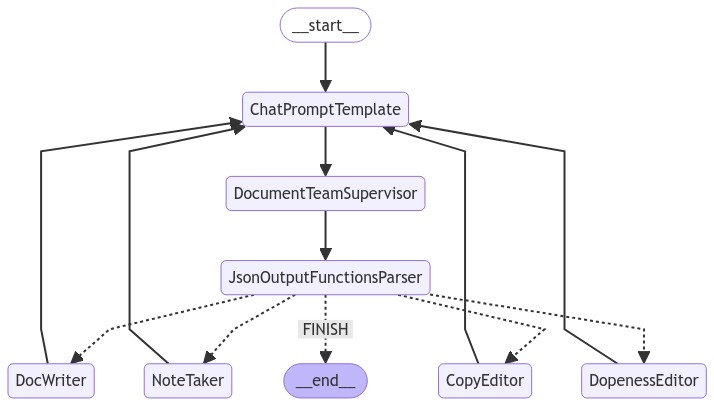

In [90]:
from IPython.display import Image, display

try:
    display(Image(authoring_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [91]:
def enter_chain(message: str, team_members: List[str]):
    results = {
        "messages_for_document_team": [HumanMessage(content=message)],
        "team_members": ", ".join([node for node in authoring_graph.nodes if node not in [ '__start__', 'DocumentTeamSupervisor']] ),
    }
    return results

authoring_e2e_chain = (
    functools.partial(enter_chain, team_members=authoring_graph.nodes)
    | authoring_graph
).with_config({'run_name':'[DocumentTeamE2EChain]'})

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [92]:
thread_info = {'configurable': {'thread_id': 'Document_checkpoint_1'}} # 😀 this is for a checkpoint!!

for s in authoring_e2e_chain.stream(
    # "Write an outline for for a short LinkedIn post on Linear Regression and write it to disk.",
    "Write a short LinkedIn post on Linear Regression and write it to disk.",
    {"recursion_limit": 100, **thread_info},
):  
    if "__end__" not in s:
        print(s)
        print("---")

{'DocumentTeamSupervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages_for_document_team': [HumanMessage(content='[Work from NoteTaker]: The outline for the LinkedIn post on Linear Regression has been successfully created and saved.', name='NoteTaker')], 'per_member_messages_for_document_team': []}}
---
{'DocumentTeamSupervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages_for_document_team': [HumanMessage(content='[Work from DocWriter]: The draft for the LinkedIn post on Linear Regression has been successfully written and saved as "LinkedIn_post_draft_1_on_Linear_Regression".', name='DocWriter')], 'per_member_messages_for_document_team': []}}
---
{'DocumentTeamSupervisor': {'next': 'CopyEditor'}}
---
{'CopyEditor': {'messages_for_document_team': [HumanMessage(content='[Work from CopyEditor]: The edited LinkedIn post on Linear Regression has been successfully saved as "LinkedIn_post_draft_2_on_Linear_Regression". This version includes improvements in clarity, engagement

In [93]:
lateset_state = authoring_graph.get_state(thread_info).values

lateset_state

{'messages_for_document_team': [HumanMessage(content='Write a short LinkedIn post on Linear Regression and write it to disk.', id='932f0932-1f90-42d6-83ff-3a3eae48b37f'),
  HumanMessage(content='[Work from NoteTaker]: The outline for the LinkedIn post on Linear Regression has been successfully created and saved.', name='NoteTaker', id='50905b98-c288-46d8-bf48-5e378487ffe5'),
  HumanMessage(content='[Work from DocWriter]: The draft for the LinkedIn post on Linear Regression has been successfully written and saved as "LinkedIn_post_draft_1_on_Linear_Regression".', name='DocWriter', id='8d751f90-0c48-4f9c-846a-1c77a9ec2a41'),
  HumanMessage(content='[Work from CopyEditor]: The edited LinkedIn post on Linear Regression has been successfully saved as "LinkedIn_post_draft_2_on_Linear_Regression". This version includes improvements in clarity, engagement, and structure to better suit the LinkedIn audience.', name='CopyEditor', id='cc58c31e-c1d4-4922-9499-eed3c919d15a'),
  HumanMessage(content

## Meta-Supervisor

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [129]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI


llm = ChatOpenAI(model="gpt-4", name="MetaSupervisorLLM").with_config({'run_name':"MetaSupervisorLLM"})

MetaSupervisor_node = get_supervisor(
    team="Meta",
    team_members=['ResearchTeam", "LinkedInTeam'],
    llm = llm,
    system_prompt="You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
)

MetaSupervisor_node

RunnableBinding(bound=RunnableBinding(bound=ChatPromptTemplate(input_variables=['messages', 'team_members'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'options': '[\'FINISH\', \'ResearchTeam", "LinkedInTeam\']'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['team_members'], template='You are a supervisor tasked with managing a conversation between the following teams: {team_members}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When all workers are finished, you must respond with FINISH.')), MessagesPlaceholder(variable_name='messages'), SystemMessagePromptTemplate(pro

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

##### 😀😀😀 The need for get_last_message and join_graph is that node needs to be a callable taking a dictionary as input and returning a dictionary as output

In [130]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages] # 😀 I prefer this!
    next: str
    team_members:List[str] # 😀 We need this!!

def get_last_message(state: State) -> str:
    if len(state["messages"])<2:
        return state["messages"][0].content
    else:
        return state["messages"][0].content + '\n\n' + state["messages"][-1].content

# 😀 Modified!!
def join_graph(response: dict):
    try:
        return {"messages": [ HumanMessage(content = '[Work from ResearchTeam]:\n' + response["messages_for_research_team"][-1].content)  ] }
    except KeyError:
        return {"messages": [ HumanMessage(content = '[Work from LinkedInTeam]:\n' + response["messages_for_document_team"][-1].content)  ] }
    

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [131]:
super_graph = StateGraph(State)

super_graph.add_node("MetaSupervisor", MetaSupervisor_node)

super_graph.add_node("ResearchTeam", get_last_message | research_e2e_chain | join_graph)
super_graph.add_node(
    "LinkedInTeam", get_last_message | authoring_e2e_chain | join_graph
)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [132]:
super_graph.add_edge("ResearchTeam", "MetaSupervisor")
super_graph.add_edge("LinkedInTeam", "MetaSupervisor")
super_graph.add_conditional_edges(
    "MetaSupervisor",
    lambda x: x["next"],
    {
        "LinkedInTeam": "LinkedInTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.set_entry_point("MetaSupervisor")
super_graph = super_graph.compile(checkpointer=checkpointer)

That's it!

Now we can finally use our full agent!

In [133]:
MetaSupervisor_node.invoke(
    input = {
                'messages': [HumanMessage(content="Write a LinkedIn post on the paper 'Extending Llama-3’s Context Ten-Fold Overnight'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk.")],
                'team_members':['ResearchTeam', 'LinkedInTeam']
            },    
)

{'next': 'ResearchTeam'}

In [134]:
thread_info = {'configurable': {'thread_id': 'Overall_checkpoint_1'}} # 😀 this is for a checkpoint!!

for s in super_graph.stream(
    input = {
                'messages': [HumanMessage(content="Write a LinkedIn post on the paper 'Extending Llama-3’s Context Ten-Fold Overnight'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk.")],
                'team_members':['ResearchTeam', 'LinkedInTeam']
            },
    config = {"recursion_limit": 30, **thread_info},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'MetaSupervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='[Work from ResearchTeam]:\n### LinkedIn Post Draft: Introducing a Breakthrough in AI Context Length\n\n🚀 **Exciting News from the AI Frontier!** 🚀\n\nWe\'re thrilled to share a groundbreaking advancement in AI technology detailed in the recent paper, "Extending Llama-3’s Context Ten-Fold Overnight," authored by an impressive team including Peitian Zhang, Ninglu Shao, Zheng Liu, Shitao Xiao, Hongjin Qian, Qiwei Ye, and Zhicheng Dou from the Beijing Academy of Artificial Intelligence and Renmin University of China.\n\n🔍 **What\'s the Big Deal?**\nThe team has successfully expanded the context length capability of the Llama-3-8B-Instruct model from 8,000 to an astonishing 80,000 tokens. This ten-fold increase was achieved through a method called QLoRA fine-tuning, all within a super-efficient eight-hour training cycle on an 8xA800 (80G) GPU machine.\n\n🌟 **Why This Matters**\nThis enhance

In [135]:
lateset_state = super_graph.get_state(thread_info).values

lateset_state

{'messages': [HumanMessage(content="Write a LinkedIn post on the paper 'Extending Llama-3’s Context Ten-Fold Overnight'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk.", id='082a6d81-abc7-4c26-a92d-6150c552df40'),
  HumanMessage(content='[Work from ResearchTeam]:\n### LinkedIn Post Draft: Introducing a Breakthrough in AI Context Length\n\n🚀 **Exciting News from the AI Frontier!** 🚀\n\nWe\'re thrilled to share a groundbreaking advancement in AI technology detailed in the recent paper, "Extending Llama-3’s Context Ten-Fold Overnight," authored by an impressive team including Peitian Zhang, Ninglu Shao, Zheng Liu, Shitao Xiao, Hongjin Qian, Qiwei Ye, and Zhicheng Dou from the Beijing Academy of Artificial Intelligence and Renmin University of China.\n\n🔍 **What\'s the Big Deal?**\nThe team has successfully expanded the context length capability of the Llama-3-8B-Instruct model from 8,000 t

### 😀😀😀 My Post!!!

### Revolutionizing AI with Llama-3's Extended Context

🚀 **Groundbreaking News from AI's Cutting Edge!** 🚀

🎉 We are beyond pumped to unveil an epic leap in AI tech, detailed in the fresh study, "Extending Llama-3’s Context Ten-Fold Overnight." Spearheaded by a top-tier crew including Peitian Zhang, Ninglu Shao, Zheng Liu, Shitao Xiao, Hongjin Qian, Qiwei Ye, and Zhicheng Dou at the Beijing Academy of Artificial Intelligence and Renmin University of China, this is a game-changer in our grasp of AI's capabilities.

🔍 **Why This Is a Big Deal**

The squad has massively bumped up the context length capacity of the Llama-3-8B-Instruct model from a mere 8,000 to a jaw-dropping 80,000 tokens. Achieved through a slick QLoRA fine-tuning method, this was pulled off in just an eight-hour power training session on an 8xA800 (80G) GPU beast.

🌟 **Why You Should Care**

This isn’t just an upgrade—it’s a revolution! Llama-3 now handles longer contexts, massively boosting its chops across tasks from health summaries to complex language puzzles. This shift isn’t just technical—it’s a radical change that could redefine how AI processes our world's data.

👩‍🔬 **Props to the Pioneers**

Big shoutout to the brainiacs behind this! Your grit and genius continue to redefine AI’s frontiers!

🔗 **Dive Into the Details**

Craving more dope insights? Check the full paper [here](https://arxiv.org/abs/2404.19553).

🤔 **What’s Next for AI?**

What do you think this means for the future of AI? Drop your thoughts below! 🚀

#ArtificialIntelligence #MachineLearning #AIResearch #Innovation #TechTrends

## SAMPLE POST!

```
A game-changing breakthrough in AI just touched down! The Llama-3-8B-Instruct model just went from cool to ultra-cool, extending its context length from 8K to a mind-blowing 80K. And guess what? It kept all its original capabilities for shorter contexts.

Talk about speed? This upgrade was pulled off in only 8 hours using an 8xA800 (80G) GPU machine. Big ups to the 3.5K synthetic training samples generated by GPT-4 that made this possible. This shows how large language models are pushing boundaries and taking giant leaps in the game.

Here's the dopest part: the squad is going all out, releasing all related resources including data, model, and training code, for everyone. This is how we move the needle, with open collaboration.

For more deets on this cutting-edge breakthrough and further upgrades, hit up our dedicated teams. We've got the info, you bring the curiosity.

#AI #MachineLearning #OpenSource #Innovation #Collaboration #Advancement
```